Some utils that we will use afterwards

In [1]:
from torch.utils.data import Dataset
from tqdm import tqdm
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"]).transpose(2,0,1)

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs


def get_bounding_box(ground_truth_map):
    """
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    """
    H, W = ground_truth_map.shape[:2]
    bbox = [0, 0, W, H]

    return bbox


### Pulling Data

We download the dataset from the server and unzip it

In [61]:
!pip install wget
import wget
url = 'https://rdr.ucl.ac.uk/ndownloader/articles/24932529/versions/1'
filename = wget.download(url)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c36ab4c79a6c5039c1e2446c6e4438b2359af154260ccc1f084c4a560814dc80
  Stored in directory: /home/jovyan/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [1]:
##unzip
import zipfile
with zipfile.ZipFile("24932529.zip","r") as zip_ref:
    zip_ref.extractall("path_to_root_data_dir")

In [65]:
for video in os.listdir('path_to_root_data_dir/'):
    if video.endswith(".zip"):
        with zipfile.ZipFile('path_to_root_data_dir/'+video,"r") as zip_ref:
            zip_ref.extractall('path_to_root_data_dir/'+video[:-4])

In [6]:
!pip install git+https://github.com/surgical-vision/SAR_RARP50-evaluation#egg=sarrarp50-toolkit


  Cloning https://github.com/surgical-vision/SAR_RARP50-evaluation to /tmp/pip-install-axrrugxq/sarrarp50-toolkit_5d9ad7d61cf643629e4234ea4f68a69b
  Running command git clone --filter=blob:none --quiet https://github.com/surgical-vision/SAR_RARP50-evaluation /tmp/pip-install-axrrugxq/sarrarp50-toolkit_5d9ad7d61cf643629e4234ea4f68a69b
  Resolved https://github.com/surgical-vision/SAR_RARP50-evaluation to commit 519280bf52034b0931a63688adee7ea16bcc42a2
  Preparing metadata (setup.py) ... done


In [4]:
import sarrarp50
from sample_video import sample_video as sample_video_u

We sample the videos with a 1Hz frequency

In [117]:
def main_sample(args):

    video_fps = 60 # all the sarrarp50 videos are recorded at 60 fps
    sampiling_period:int =video_fps//args.frequency

    # find all the files that need to be processed
    """
    if not args.recursive:
        #video_dirs = [Path(args.data_dir).resolve()]
        video_dirs = [Path('path_to_root_data_dir').resolve()]
    else:
        #video_dirs = [v_p.parent for v_p in Path(args.data_dir).rglob('*video_left.avi')]
        """
    video_dirs = [v_p.parent for v_p in Path('path_to_root_data_dir').rglob('*video_left.avi')]
    # validate paths
    
    for directory in video_dirs:
        if not (directory.exists() and (directory/'video_left.avi').exists()):
            print(f"{directory} does not a video directory. please make sure video directory path is correct")
    
    for directory in video_dirs:#, desc='unpacking dataset', bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        rgb_dir = (directory/'rgb')
        sample_video_u(directory/'video_left.avi', rgb_dir, sampiling_period, args.jobs)

In [118]:
parser = argparse.ArgumentParser()
parser.add_argument('data_dir', help='path pointing to the video or dataset directory',default='path_to_root_data_dir')
parser.add_argument('-f', '--frequency', type=int, help='sampling rate in Hz', choices= [1, 10], default=1)
parser.add_argument('-r', '--recursive', help='search recursively for video directories that have video_left.avi as a child', action='store_true')
parser.add_argument('-j', '--jobs', help='number of parallel works to use when saving images', default=4, type=int)
args = parser.parse_args(sys.argv[2:])
SystemExit(main_sample(args))


SystemExit(None)

### Model

We import the data path


In [2]:
#from PIL import Image 
import numpy as np
from pathlib import Path

list_path = [[],[]]
for par in np.unique([v_p.parent.parent for v_p in Path('path_to_root_data_dir').rglob('*.png')]):
    for video in [v_p for v_p in Path(par/'rgb').rglob('*.png')]:
        list_path[0].append(str(video))
        list_path[1].append(str(par/'segmentation'/video.name))
list_path[0] = list_path[0]
list_path[1] = list_path[1]

In [3]:
!pip install datasets

  Using cached datasets-2.19.1-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached multiprocess-0.70.16-py311-none-any.whl (143 kB)


We open the training set

In [4]:

from datasets import load_dataset,Dataset, Image
dataset = Dataset.from_dict({'label' : list_path[1],  'image' : list_path[0]}).cast_column("image", Image()).cast_column("label", Image())
#dataset = load_dataset("nielsr/breast-cancer", split="train")

Let's resize the images and flip some of them randomly

In [5]:
ind_flip = np.random.choice(np.arange(len(dataset)), int(len(dataset)/5))
from PIL import Image 
def transforms_image(examples):
    examples["image"] = [image.resize((256,256)) for image in examples["image"]]
    examples["image"] = [image.transpose(Image.FLIP_LEFT_RIGHT) if k in ind_flip else image for k,image in enumerate(examples["image"])]
    
    return examples

dataset = dataset.map(transforms_image, batched=True)

def transforms_label(examples):
    examples["label"] = [image.resize((256,256)) for image in examples["label"]]
    examples["label"] = [image.transpose(Image.FLIP_LEFT_RIGHT) if k in ind_flip else image for k,image in enumerate(examples["label"])]

    return examples
dataset = dataset.map(transforms_label, batched=True)

Map:   0%|          | 0/13043 [00:00<?, ? examples/s]

Map:   0%|          | 0/13043 [00:00<?, ? examples/s]

Let's look at some examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

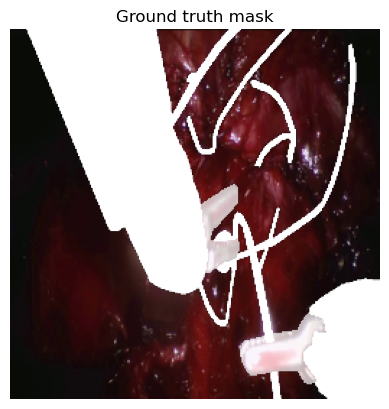

In [6]:
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([1, 1, 1,0.7])
    h, w, c = mask.shape

    mask_image = np.expand_dims(np.mean(mask, axis = 2), axis=2) * color.reshape(1, 1, -1)
    return mask_image

fig, axes = plt.subplots()


ground_truth_seg = np.array(dataset[100]["label"])
axes.imshow(dataset[100]['image'])
axes.imshow(show_mask(ground_truth_seg, axes))

axes.title.set_text(f"Ground truth mask")
axes.axis("off")
     

In [6]:
## filter applied on pictures
from scipy.ndimage import laplace
from numpy import asarray
from PIL import Image
for ind in range(len(dataset)):
    dataset[ind]['image'] = Image.fromarray(asarray(dataset[ind]['image'])+laplace(asarray(dataset[6]['image'])))


In [7]:
## data processing loading
!pip install -q git+https://github.com/huggingface/transformers.git datasets
import torch
from transformers import SamModel, SamProcessor
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

train_dataset = SAMDataset(dataset=dataset, processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)


In [8]:
## finetunning
!pip install monai

  Using cached monai-1.3.0-202310121228-py3-none-any.whl.metadata (10 kB)
Using cached monai-1.3.0-202310121228-py3-none-any.whl (1.3 MB)


In [9]:
## classification head
from fpn.factory import make_fpn_efficientnet

model_classi = make_fpn_efficientnet(
	name='efficientnet_b0',
	fpn_type='fpn',
	pretrained=True,
	num_classes=11,
	fpn_channels=128,
	in_channels=4,
	out_size=(256, 256))

Using cache found in /home/jovyan/.cache/torch/hub/lukemelas_EfficientNet-PyTorch_master


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


Using cache found in /home/jovyan/.cache/torch/hub/lukemelas_EfficientNet-PyTorch_master


In [10]:
## segmentation model
from torch.optim import Adam
import monai
from transformers import SamModel 
from torch import nn

model = SamModel.from_pretrained("facebook/sam-vit-base")

#checkpoint = torch.load('./sam.pt')
#model.load_state_dict(checkpoint)# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)



In [78]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


def Double_Conv(input_channel, output_channel):
     return nn.Sequential(
          nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(output_channel),
          nn.ReLU(inplace=True),
          nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(output_channel),
          nn.ReLU(inplace=True))

class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 11, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [11]:
from torch import nn



    
class model_classify(nn.Module):
    def __init__(self, sam,classi):
        super().__init__()
        self.sam = sam
        self.classi = classi
        #self.linear = nn.Linear(3,11)

    def forward(self,pixel_values,input_boxes,multimask_output):
        
        outputs = self.sam(pixel_values = pixel_values,input_boxes = input_boxes,multimask_output = multimask_output)
        outputs_mask = outputs.pred_masks.squeeze(1)
        outputs = F.sigmoid(outputs.pred_masks.squeeze(1))
        z = (outputs>0.5).int()
        mask = (z == 0)
        z = z * (~mask)
        z = torch.concatenate([z , Resize((256,256))(pixel_values)],axis = 1)
        z = self.classi(z)
        '''
        N,C,H,W = predicted_masks.shape
        predicted_masks = predicted_masks.permute(0,2,3,1).contiguous()
        predicted_masks = predicted_masks.reshape(N*H*W,C)
        predicted_masks = self.linear(predicted_masks)
        predicted_masks = predicted_masks.reshape(N,H,W,11)
        predicted_masks = predicted_masks.permute(0,3,1,2).contiguous()
        '''
        return z,outputs_mask

In [12]:
model_class = model_classify(model, model_classi)#,model_unet)
checkpoint = torch.load('./sam_classification_2.pt')
model_class.load_state_dict(checkpoint)
model_class.to(device)
model_class.train()
model_class.classi.train()

optimizer = Adam(model_class.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
seg_loss_class = monai.losses.DiceCELoss( squared_pred=True, reduction='mean')

In [19]:
for name, param in model_class.sam.named_parameters():
  if name.startswith("vision_decoder"):
    param.requires_grad_(False)

In [21]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from monai.networks import one_hot
from torchvision.transforms import Resize
import torch.nn.functional as F
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"




for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs, outputs_mask = model_class(pixel_values = batch["pixel_values"].to(device),
                      input_boxes = batch["input_boxes"].to(device),
                      multimask_output = False)
      #outputs = outputs.squeeze(1)
      # compute loss
      outputs = torch.softmax(outputs, axis = 1)
      ground_truth_masks = torch.mean(batch["ground_truth_mask"].float(), axis = 1).to(device).unsqueeze(1)
      loss = seg_loss_class(outputs, one_hot(ground_truth_masks, num_classes = 11)) #+  seg_loss(outputs_mask, ground_truth_masks)

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 6522/6522 [1:50:49<00:00,  1.02s/it]


EPOCH: 0
Mean loss: 2.04064880553216


 15%|█▍        | 970/6522 [15:20<1:27:48,  1.05it/s]


KeyboardInterrupt: 

In [ ]:
## eval

In [14]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.mean(np.array(dataset[100]["label"]), axis = 2)
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(dataset[100]['image'], input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [15]:
model_class.eval()

# forward pass
with torch.no_grad():
  outputs,_ = model_class(inputs['pixel_values'], inputs['input_boxes'], multimask_output=False)


medsam_seg_prob = torch.softmax(outputs, axis = 1)
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = np.argmax(medsam_seg_prob, axis = 0).astype(np.uint8)
     

(-0.5, 255.5, 255.5, -0.5)

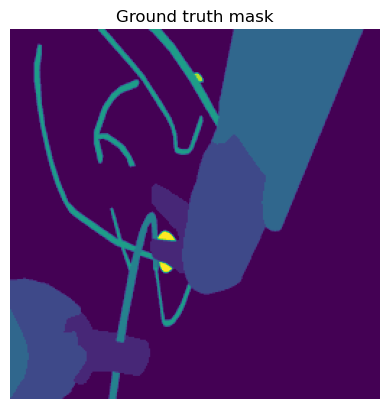

In [19]:
fig, axes = plt.subplots()
axes.imshow(np.array(dataset[100]['label']).mean(axis = 2)*1)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

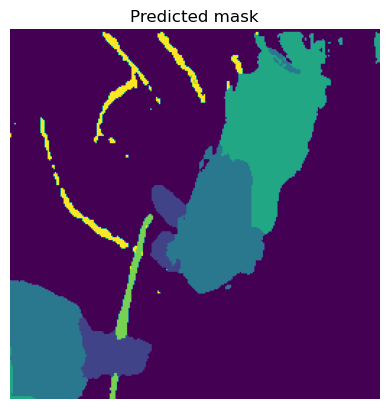

In [18]:
fig, axes = plt.subplots()
axes.imshow(medsam_seg*1)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

In [146]:
## comparison of labels between predicted and real
np.unique(medsam_seg, return_counts = True),np.unique(np.array(dataset[100]['label']).mean(axis = 2), return_counts = True)

((array([0, 1, 2, 3, 4, 5], dtype=uint8),
  array([49196,  1405,  7605,  5755,   660,   915])),
 (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
  array([43383,  2884,  8066,  8680,   847,  1560,    10,    12,    23,
            71])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

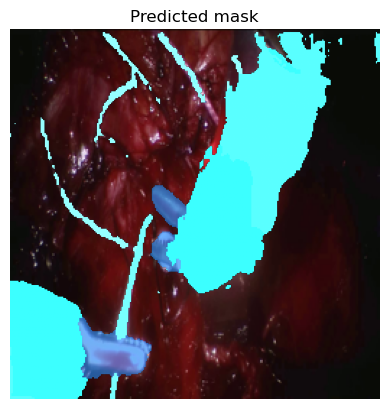

In [17]:
import matplotlib.pyplot as plt
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(dataset[100]['image']))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")
     

In [20]:
torch.save(model_class.state_dict(),'sam_classification_3.pt')